In [1]:
from preprocess_images import *
import pandas as pd
import numpy as np
import os
import glob
import random
import cv2 as cv
import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
# This is needed to display the images.
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (9, 9)

In [8]:
# original images
PATH = os.getcwd()
PATH_TO_ANNO = 'annotations/'
ANNO_TABLE = 'BusAnnotation.csv'
PATH_TO_IMAGES = 'images/originals/'
PATH_TO_RESIZED_IMAGES = 'images/resized/'
# augmented images
PATH_TO_AUG_IMAGES = 'aug_images/'

In [4]:
df = pd.read_csv(os.path.join(PATH_TO_ANNO, ANNO_TABLE))

In [5]:
df.head(8)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,DSCF1013.JPG,3648,2736,1,1217,1690,1706,1891
1,DSCF1013.JPG,3648,2736,2,1774,1619,2249,1843
2,DSCF1013.JPG,3648,2736,3,2313,1566,2773,1794
3,DSCF1013.JPG,3648,2736,4,1284,1832,1781,2063
4,DSCF1013.JPG,3648,2736,5,1879,1798,2365,2026
5,DSCF1013.JPG,3648,2736,6,2429,1742,2904,1970
6,DSCF1015.JPG,3648,2736,3,641,1342,1822,2234
7,DSCF1015.JPG,3648,2736,6,2053,1022,3175,1757


In [6]:
imresize_to_300x225(PATH_TO_IMAGES, PATH_TO_RESIZED_IMAGES, df=df)

In [7]:
# new scaled df
df.head(8)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,s_DSCF1013.JPG,300,225,1,100,138,140,155
1,s_DSCF1013.JPG,300,225,2,145,133,184,151
2,s_DSCF1013.JPG,300,225,3,190,128,228,147
3,s_DSCF1013.JPG,300,225,4,105,150,146,169
4,s_DSCF1013.JPG,300,225,5,154,147,194,166
5,s_DSCF1013.JPG,300,225,6,199,143,238,162
6,s_DSCF1015.JPG,300,225,3,52,110,149,183
7,s_DSCF1015.JPG,300,225,6,168,84,261,144


In [8]:
# save resized anno table
df.to_csv(os.path.join(PATH_TO_ANNO, 'bus_anno_resized.csv'), index=False)

In [9]:
[filenames, images, bboxes, classes] = get_images_bboxes(df=df, path_to_images=PATH_TO_RESIZED_IMAGES)

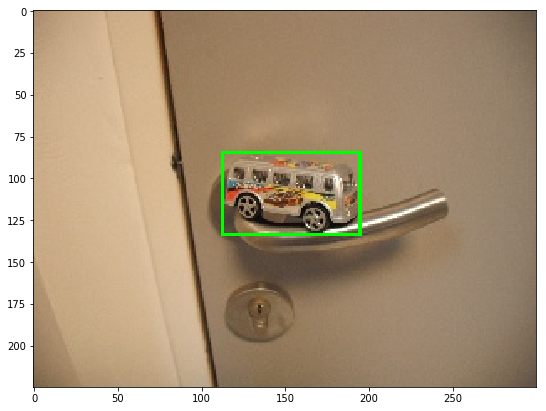

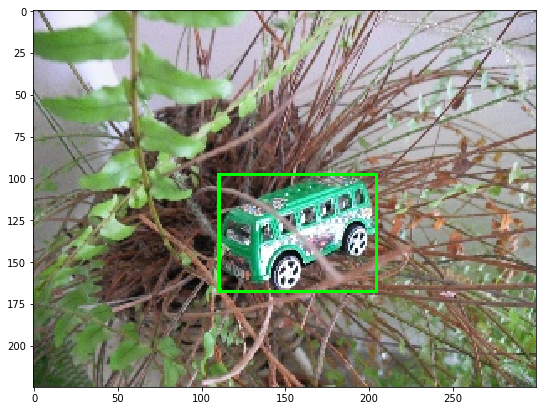

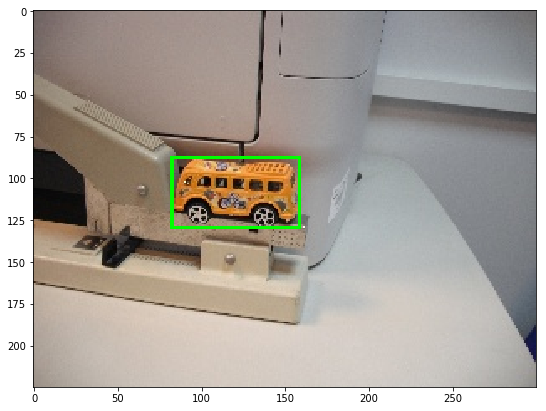

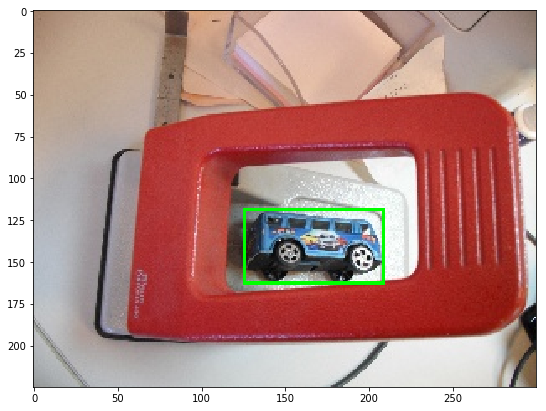

In [10]:
imshow_bbox(images, bboxes, 4)

In [11]:
df.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,s_DSCF1013.JPG,300,225,1,100,138,140,155
1,s_DSCF1013.JPG,300,225,2,145,133,184,151
2,s_DSCF1013.JPG,300,225,3,190,128,228,147
3,s_DSCF1013.JPG,300,225,4,105,150,146,169
4,s_DSCF1013.JPG,300,225,5,154,147,194,166
5,s_DSCF1013.JPG,300,225,6,199,143,238,162
6,s_DSCF1015.JPG,300,225,3,52,110,149,183
7,s_DSCF1015.JPG,300,225,6,168,84,261,144
8,s_DSCF1016.JPG,300,225,4,87,151,179,201
9,s_DSCF1016.JPG,300,225,6,160,105,244,151


In [12]:
sometimes08 = lambda aug: iaa.Sometimes(0.8, aug)
sometimes05 = lambda aug: iaa.Sometimes(0.5, aug)

def seq_det_aug():
    seq = iaa.Sequential([iaa.Multiply(mul=(0.75, 1.25)),
                          iaa.Add(value=(-40, 40)),
                          iaa.Fliplr(0.5),
                          
                          sometimes08(iaa.OneOf([iaa.CoarseDropout((0.01, 0.1), size_percent=(0.02, 0.05)),
                                                 iaa.GaussianBlur(sigma=(0.0, 1.0))])),

                          sometimes08(iaa.OneOf([iaa.Grayscale(alpha=(0.0, 0.1)),
                                                 iaa.ContrastNormalization((0.8, 1.2)),
                                                 iaa.Superpixels(p_replace=0.1, n_segments=1024)])),
                          
                          sometimes05(iaa.OneOf([iaa.AdditiveGaussianNoise(scale=(0, 0.01*255)),
                                                 iaa.AverageBlur(k=((1, 3), (1, 3))),
                                                 iaa.AddElementwise((-10, 10)),
                                                 iaa.Sharpen(alpha=(0.2, 0.8), lightness=(0.75, 1.5))])),
                                                    
                          sometimes08(iaa.Affine(
                                    scale=(0.7, 1.3), # scale images to 80-120% of their size, individually per axis
                                    translate_percent=(-0.2, 0.2), # translate by -20 to +20 percent (per axis)
                                    rotate=(-15, 15),
                                    shear=(-12, 12),
                                    order=3, # interpolation
                                    cval=[100,200])) # if mode is constant, use cval 0
                         ])
    seq_det = seq.to_deterministic() # call this for each batch again, NOT only once at the start
    return seq_det

In [13]:
batches_to_concat = []
batch = 100
for i in range(batch):
    if (i == 0):
        seq = iaa.Noop()
    else:
        seq = seq_det_aug()
        
    images_aug = seq.augment_images(images)
    bboxes_aug = seq.augment_bounding_boxes(bboxes)
    filename_aug_batch = [str(i).zfill(2) + '_' + f for f in filenames]
    df_batch = imwrite_aug_ssd(images_aug, filename_aug_batch, bboxes_aug,
                               classes, os.path.join(PATH, PATH_TO_AUG_IMAGES))
    batches_to_concat.append(df_batch.copy())
#     imshow_bbox(images_aug, bboxes_aug, 2)

df_aug = pd.concat(batches_to_concat)
df_aug.to_csv(os.path.join(PATH_TO_ANNO, 'bus_anno_aug.csv'), index=None)

In [24]:
print('Num of objects in the training set:', len(df_aug['filename'].tolist()))
print('Num of images in the training set:', len(list(set(df_aug['filename'].tolist()))))

Num of objects in the training set: 10396
Num of images in the training set: 6000


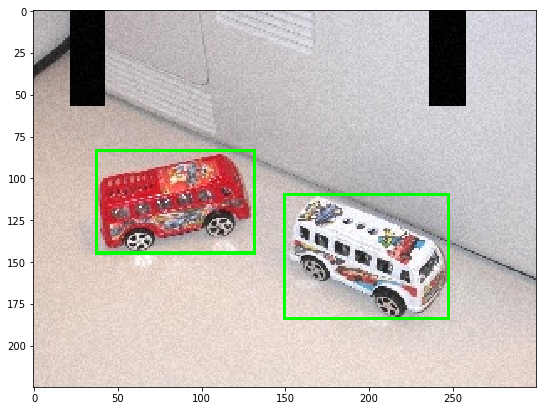

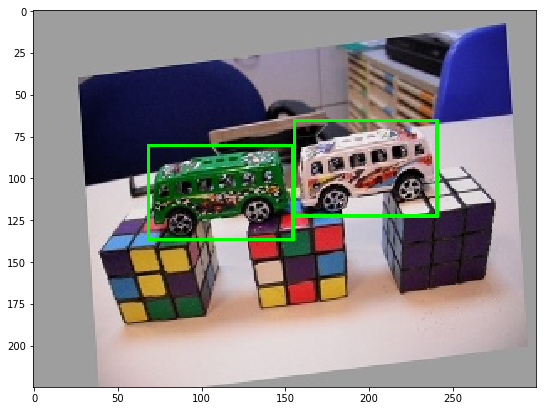

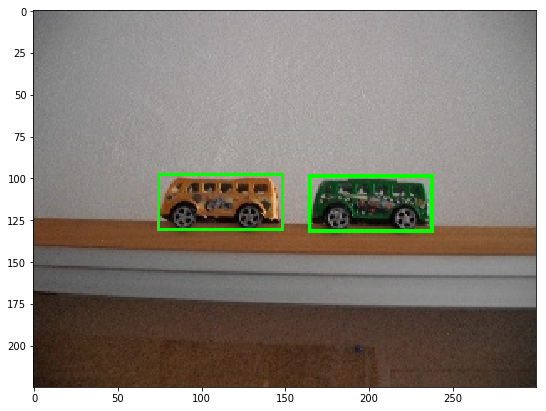

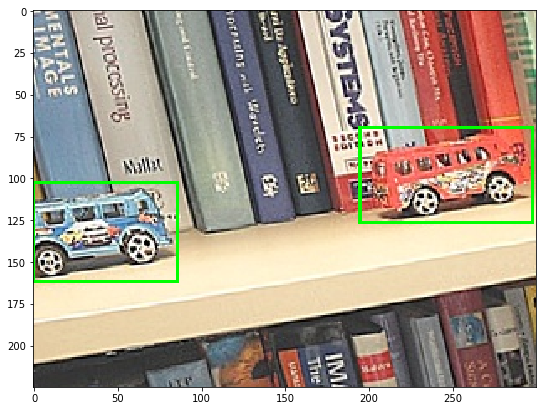

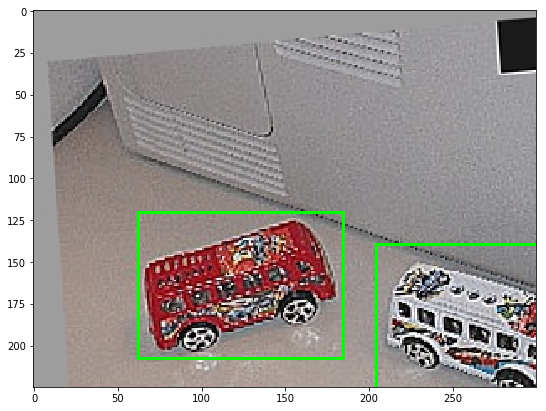

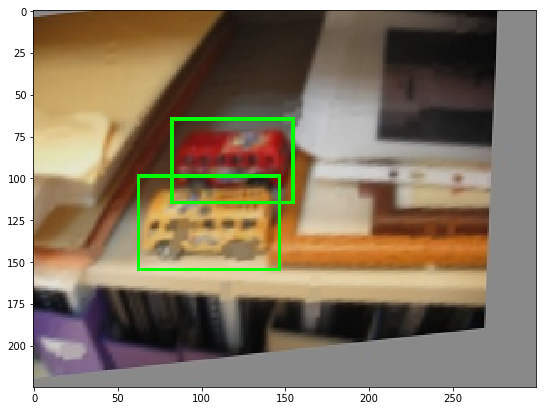

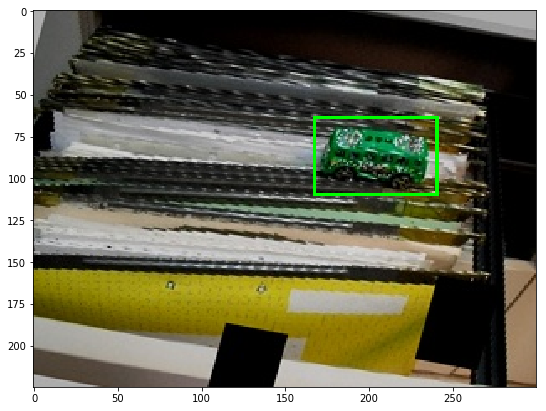

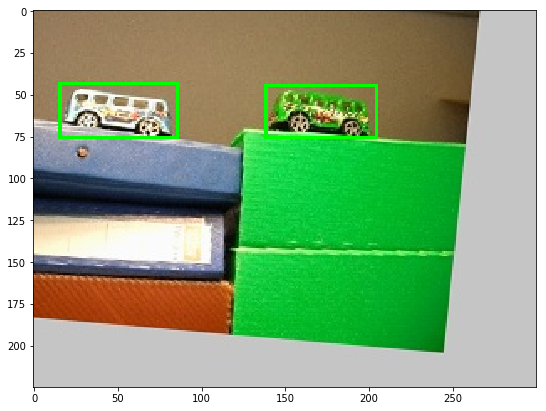

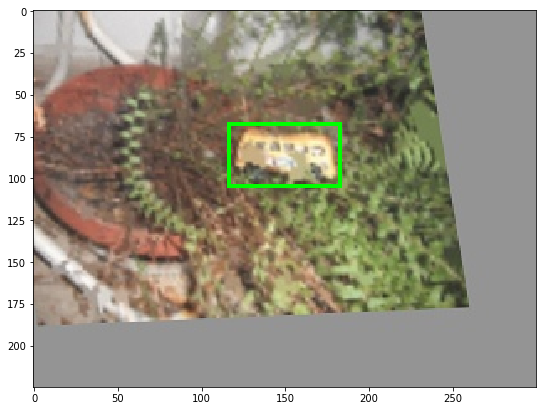

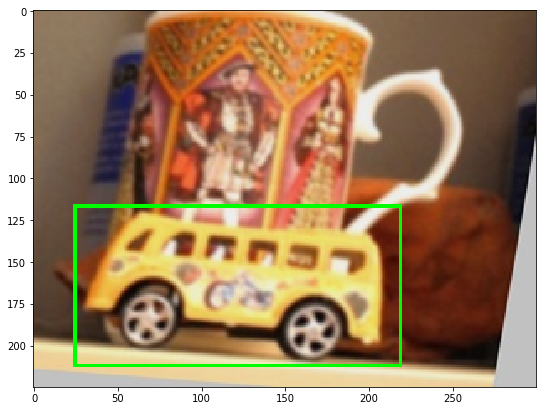

In [15]:
# test augmentation
[_, img_t, bb_t, _] = get_images_bboxes(df=df_aug, path_to_images=PATH_TO_AUG_IMAGES)
imshow_bbox(img_t, bb_t, 10)

In [9]:
# split the data to tarin (90%) and test (10%) sets
original_images = glob.glob(PATH_TO_IMAGES + '*.JPG')
original_images = list(map(lambda s: s[-8:-4], original_images))

In [30]:
to_test_images = np.random.choice(original_images, size=6)
print('images to test set: {}'.format(to_test_images))

images to test set: ['1025' '1133' '1015' '1120' '1070' '1099']


In [12]:
df_aug = pd.read_csv(os.path.join(PATH_TO_ANNO, 'bus_anno_aug.csv'))

In [31]:
df_aug_test = df_aug[df_aug.apply(lambda x: x['filename'][-8:-4] in to_test_images, axis=1)]

In [32]:
df_aug_train = df_aug[df_aug.apply(lambda x: x['filename'][-8:-4] not in to_test_images, axis=1)]

In [33]:
df_aug_train.to_csv(os.path.join(PATH_TO_ANNO, 'bus_anno_aug_train_fold4.csv'), index=False)
df_aug_test.to_csv(os.path.join(PATH_TO_ANNO, 'bus_anno_aug_test_fold4.csv'), index=False)

In [34]:
# review part of the train set 
df_aug_train[df_aug_train.apply(lambda x: x['filename'][-8:-4] == '1013', axis=1)]

,filename,width,height,class,xmin,ymin,xmax,ymax,path
13,00_s_DSCF1013.JPG,300,225,1,100,138,140,155,/home/sha_maayan/busProject/6_classes/augmenta...
14,00_s_DSCF1013.JPG,300,225,2,145,133,184,151,/home/sha_maayan/busProject/6_classes/augmenta...
15,00_s_DSCF1013.JPG,300,225,3,190,128,228,147,/home/sha_maayan/busProject/6_classes/augmenta...
16,00_s_DSCF1013.JPG,300,225,4,105,150,146,169,/home/sha_maayan/busProject/6_classes/augmenta...
17,00_s_DSCF1013.JPG,300,225,5,154,147,194,166,/home/sha_maayan/busProject/6_classes/augmenta...
18,00_s_DSCF1013.JPG,300,225,6,199,143,238,162,/home/sha_maayan/busProject/6_classes/augmenta...
117,01_s_DSCF1013.JPG,300,225,1,123,151,167,175,/home/sha_maayan/busProject/6_classes/augmenta...
118,01_s_DSCF1013.JPG,300,225,2,171,152,214,177,/home/sha_maayan/busProject/6_classes/augmenta...
119,01_s_DSCF1013.JPG,300,225,3,219,153,261,180,/home/sha_maayan/busProject/6_classes/augmenta...
120,01_s_DSCF1013.JPG,300,225,4,129,165,174,191,/home/sha_maayan/busProject/6_classes/augmenta...
